# 🌸 FLOWER CLASSIFICATION WITH MOBILENETV2 & SMART PADDING
(XÂY DỰNG MÔ HÌNH PHÂN LOẠI CÁC LOÀI HOA BẰNG KỸ THUẬT HỌC CHUYỂN GIAO VỚI KIẾN TRÚC MOBILENETV2)

---
### 👤 AUTHOR INFO
* **Tác giả:** Bùi Tiến Phát
* **Email:** higo.individual@gmail.com
* **Project Type:** Nghiên cứu cá nhân / Thị giác máy tính
* **Kỹ thuật:** Transfer Learning, Smart Padding, I/O Optimization.

---
### 📝 SYSTEM OVERVIEW:

**1. Mục tiêu:**
Huấn luyện mô hình Deep Learning có khả năng phân loại chính xác 6 loài hoa: *Black-eyed Susan, Calendula, California Poppy, Common Daisy, Coreopsis, Sunflower*.

**2. Công nghệ & Kỹ thuật áp dụng:**
* **Mô hình cơ sở:** **MobileNetV2** (Pre-trained trên ImageNet) - Đảm bảo độ chính xác cao nhưng nhẹ và nhanh.
* **Kỹ thuật chính:** **Học chuyển giao (Transfer Learning)** - Đóng băng các lớp đặc trưng và chỉ huấn luyện lại lớp phân loại (Classifier Head).
* **Tối ưu hóa Huấn luyện (Performance Optimization):**
    * Sử dụng kỹ thuật **Copy & Giải nén (.rar) trên ổ cứng Local Colab** để tăng tốc độ đọc dữ liệu (I/O) gấp ~40 lần so với đọc trực tiếp từ Drive.
    * Sử dụng `tf.data.Dataset` với `.cache()` và `.prefetch()` để tối ưu hóa luồng dữ liệu GPU.
* **Chống Overfitting:** Áp dụng Data Augmentation (Tăng cường dữ liệu) và Dropout.

**3. Kết quả thực nghiệm:**
* **Độ chính xác (Val Accuracy):** ~91%
* **Kiểm thử thực tế (Test Set):** Dự đoán chính xác 6/6 ảnh thực tế (bao gồm cả ảnh chất lượng cao và ảnh méo tỷ lệ).

**BƯỚC 1: THIẾT LẬP MÔI TRƯỜNG VÀ CHUẨN BỊ DỮ LIỆU (Auto Download)**

**Mục tiêu:** Tự động tải dữ liệu từ Cloud, giải nén vào ổ cứng cục bộ (Local Disk) của Colab để tối ưu hóa tốc độ huấn luyện.


In [ ]:
# 1: KHAI BÁO CÁC THƯ VIỆN CẦN THIẾT
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gdown # Thư viện tải file từ Drive công khai
from sklearn.metrics import confusion_matrix, classification_report

print(f"--> TensorFlow phiên bản: {tf.__version__}")
print(f"--> Keras phiên bản: {tf.keras.__version__}")

--> TensorFlow phiên bản: 2.19.0
--> Keras phiên bản: 3.10.0


In [ ]:
# 2: TẢI DỮ LIỆU TỪ DRIVE
file_id = "1Th2ZKlylH-XsxvRPHmrHHZlEb81cKwTk"
url = f"https://drive.google.com/uc?id={file_id}"

# Vị trí lưu file nén tại Local Colab
LOCAL_DESTINATION = "/content/"
LOCAL_RAR_PATH = os.path.join(LOCAL_DESTINATION, "Flower_Images.rar")

print(f"--> Đang tải dữ liệu từ Google Drive (ID: {file_id})...")
start_time = time.time()
gdown.download(url, LOCAL_RAR_PATH, quiet=False)
print(f"Tải hoàn tất. Thời gian: {time.time() - start_time:.2f} giây.")

# 3: GIẢI NÉN DỮ LIỆU (TỐI ƯU HÓA)
# Cài đặt thư viện "unrar" (nếu chưa có)
print('--> Đang cài đặt công cụ giải nén "unrar"...')
!sudo apt-get install unrar -y > /dev/null

# Thực hiện Giải nén
print(f"--> Đang giải nén dữ liệu tại: {LOCAL_DESTINATION}...")
start_time = time.time()
# x: giải nén giữ nguyên cấu trúc, -o+: ghi đè nếu tồn tại
!unrar x -o+ "{LOCAL_RAR_PATH}" "{LOCAL_DESTINATION}" > /dev/null
print(f"Giải nén hoàn tất. Thời gian: {time.time() - start_time:.2f} giây.")

--> Đang tải dữ liệu từ Google Drive (ID: 1Th2ZKlylH-XsxvRPHmrHHZlEb81cKwTk)...


Downloading...
From (original): https://drive.google.com/uc?id=1Th2ZKlylH-XsxvRPHmrHHZlEb81cKwTk
From (redirected): https://drive.google.com/uc?id=1Th2ZKlylH-XsxvRPHmrHHZlEb81cKwTk&confirm=t&uuid=3d20cb9d-fa88-4891-a3c1-99f2e38eb85c
To: /content/Flower_Images.rar
100%|██████████| 79.7M/79.7M [00:01<00:00, 67.8MB/s]


Tải hoàn tất. Thời gian: 4.53 giây.
--> Đang cài đặt công cụ giải nén "unrar"...
--> Đang giải nén dữ liệu tại: /content/...
Giải nén hoàn tất. Thời gian: 1.61 giây.


**BƯỚC 2: TẢI DỮ LIỆU VÀ TRỰC QUAN HÓA (Input)**

**Mục tiêu:** Thiết lập Pipeline dữ liệu và kiểm tra phân bố của các lớp.

In [ ]:
# 3: THIẾT LẬP CÁC ĐƯỜNG DẪN VÀ THAM SỐ ẢNH
# file .rar giải nén ra thư mục 'Flower Images'
BASE_DIR = '/content/Flower Images'

# Đường dẫn đến thư mục huấn luyện
train_dir = os.path.join(BASE_DIR, 'flowers')

# Đường dẫn đến thư mục kiểm tra
test_dir = os.path.join(BASE_DIR, 'Test_Images')

# Kiểm tra
print(f"Đường dẫn huấn luyện: {train_dir}")
print(f"Đường dẫn kiểm tra: {test_dir}")

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)

Đường dẫn huấn luyện: /content/Flower Images/flowers
Đường dẫn kiểm tra: /content/Flower Images/Test_Images


In [ ]:
# 4: TẠO DATASET TỪ THƯ MỤC (Sử dụng tf.data.Dataset)
# Tải tập Training (80% dữ liệu từ thư mục 'flowers')
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,  # Tự động chia 20% cho validation
    subset="training",     # Chọn tập training
    seed=123,              # Seed để đảm bảo việc chia là cố định
    image_size=IMAGE_SIZE, # Tự động resize tất cả ảnh về 224x224
    batch_size=BATCH_SIZE
)

# Tải tập Validation (20% còn lại từ thư mục 'flowers')
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",   # Chọn tập validation
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_dataset.class_names
print(f"Các lớp (loài hoa) đã được tìm thấy: {class_names}")
print(f"Tổng số lớp: {len(class_names)}")

Found 6054 files belonging to 6 classes.
Using 4844 files for training.
Found 6054 files belonging to 6 classes.
Using 1210 files for validation.
Các lớp (loài hoa) đã được tìm thấy: ['black_eyed_susan', 'calendula', 'california_poppy', 'common_daisy', 'coreopsis', 'sunflower']
Tổng số lớp: 6



--> Hiển thị mẫu dữ liệu đầu vào:


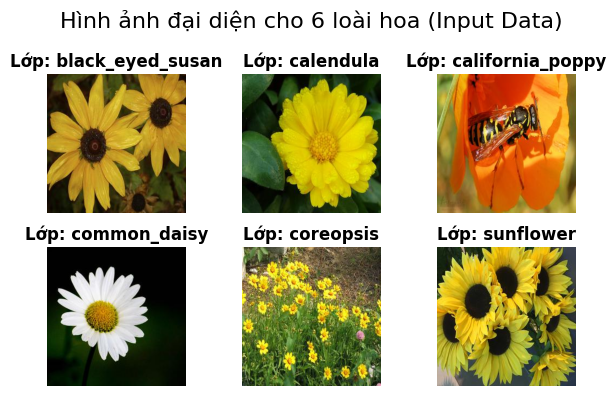

In [ ]:
# 5: TRỰC QUAN HÓA DỮ LIỆU MẪU (Representative Images)
def plot_representative_images(data_dir, class_names):
    plt.figure(figsize=(6, 4))
    for i, class_name in enumerate(class_names):
        # Lấy ảnh đầu tiên của mỗi lớp để làm mẫu
        folder_path = os.path.join(data_dir, class_name)
        first_img = os.listdir(folder_path)[0]
        img_path = os.path.join(folder_path, first_img)

        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, 3, i + 1)
            plt.imshow(img)
            plt.title(f"Lớp: {class_name}", fontsize=12, fontweight='bold')
            plt.axis("off")
    plt.suptitle("Hình ảnh đại diện cho 6 loài hoa (Input Data)", fontsize=16)
    plt.tight_layout()
    plt.show()

print("\n--> Hiển thị mẫu dữ liệu đầu vào:")
plot_representative_images(train_dir, class_names)

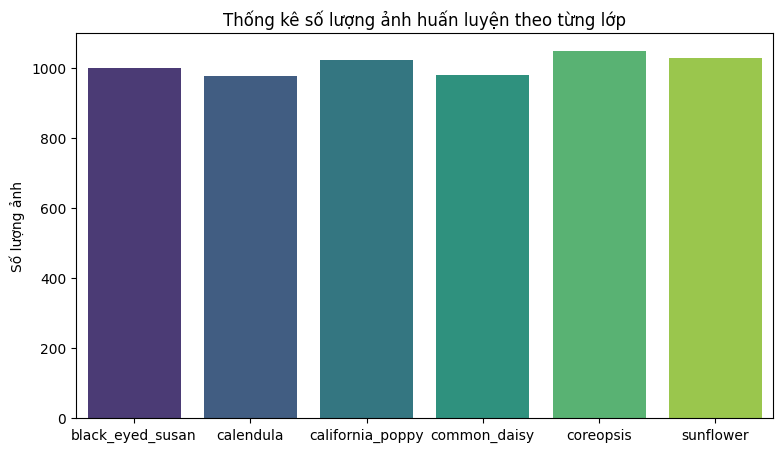

In [ ]:
# 6: BIỂU ĐỒ PHÂN BỐ DỮ LIỆU (Data Distribution)
def plot_distribution(data_dir, class_names):
    counts = [len(os.listdir(os.path.join(data_dir, name))) for name in class_names]
    plt.figure(figsize=(9, 5))
    sns.barplot(x=class_names, y=counts, palette='viridis', hue=class_names, legend=False)
    plt.title('Thống kê số lượng ảnh huấn luyện theo từng lớp')
    plt.ylabel('Số lượng ảnh')
    plt.show()

plot_distribution(train_dir, class_names)

In [ ]:
# 7: TỐI ƯU HÓA HIỆU NĂNG (Caching & Prefetching)
AUTOTUNE = tf.data.AUTOTUNE
# .cache() sẽ làm Epoch 1 chạy hơi chậm (để nạp vào RAM), các epoch sau sẽ nhanh hơn gấp nhiều lần.
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Đã tối ưu hóa bộ dữ liệu (train_ds, val_ds)!")

Đã tối ưu hóa bộ dữ liệu (train_ds, val_ds)!


**BƯỚC 3: XÂY DỰNG MÔ HÌNH HỌC CHUYỂN GIAO (Transfer Learning)**

**Kiến trúc:** MobileNetV2 (Pre-trained trên ImageNet)

In [ ]:
# 8: XÂY DỰNG LỚP TĂNG CƯỜNG DỮ LIỆU (Data Augmentation)
# Giúp mô hình tránh Overfitting bằng cách tạo biến thể ảnh
data_augmentation = tf.keras.Sequential(
    [
        # Thêm input_shape vào lớp đầu tiên
        tf.keras.layers.RandomFlip("horizontal",
                                  input_shape=(IMG_HEIGHT,
                                               IMG_WIDTH,
                                               3)),
        tf.keras.layers.RandomRotation(0.1), # Xoay ngẫu nhiên 10%
        tf.keras.layers.RandomZoom(0.1),     # Zoom ngẫu nhiên 10%
    ],
    name="data_augmentation"
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 9: TẢI MÔ HÌNH CƠ SỞ (Base Model) - MobileNetV2
# Tạo hình dạng input (chiều cao, chiều rộng, 3 kênh màu)
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Tải hàm tiền xử lý của MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Tải mô hình cơ sở (base model), bỏ lớp phân loại gốc (include_top=False), và dùng trọng số 'imagenet'
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Không lấy lớp Fully Connected cuối
                                               weights='imagenet')

# Đóng băng (Freeze) mô hình gốc để giữ lại các đặc trưng đã học
base_model.trainable = False

print("Đã tải và đóng băng Base Model (MobileNetV2)!.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Đã tải và đóng băng Base Model (MobileNetV2)!.


In [ ]:
# 10: XÂY DỰNG KIẾN TRÚC MÔ HÌNH HOÀN CHỈNH
inputs = tf.keras.Input(shape=IMG_SHAPE, name="Input_Layer") # Định nghĩa đầu vào (Input)
x = data_augmentation(inputs)        # Lớp Tăng cường ảnh (chỉ hoạt động khi training)
x = preprocess_input(x)              # Lớp Tiền xử lý (chuẩn hóa pixel)
x = base_model(x, training=False)    # Trích xuất đặc trưng, (training=False) là bắt buộc khi base_model bị đóng băng
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Avg_Pool")(x) # Giảm chiều dữ liệu, làm phẳng "đầu ra" 3D
x = tf.keras.layers.Dropout(0.2, name="Dropout")(x)                   # Chống Overfitting (Dropout)

# Lớp đầu ra (Output Layer) cho 6 loài hoa, dùng 'softmax' cho bài toán phân loại nhiều lớp
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name="Output_Classifier")(x)

# Gộp lại thành mô hình cuối cùng
model = tf.keras.Model(inputs, outputs, name="Flower_Classifier_MobileNetV2")

In [ ]:
# 11: BIÊN DỊCH MÔ HÌNH
# Sử dụng Adam optimizer với learning rate mặc định
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Hiển thị tóm tắt kiến trúc
model.summary()

Model: "Flower_Classifier_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Global_Avg_Pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Classifier (Dense)       │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**BƯỚC 4: HUẤN LUYỆN MÔ HÌNH (Training)**

In [ ]:
# 12: HUẤN LUYỆN MÔ HÌNH
# Quá trình huấn luyện sẽ lưu lại vào biến 'history'
EPOCHS = 10 # Bắt đầu với 10 epochs
print("Bắt đầu huấn luyện...")
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)
print("Huấn luyện hoàn tất!")

Bắt đầu huấn luyện...
Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.5728 - loss: 1.1591 - val_accuracy: 0.8479 - val_loss: 0.4532
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8682 - loss: 0.4124 - val_accuracy: 0.8868 - val_loss: 0.3491
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8985 - loss: 0.3334 - val_accuracy: 0.9041 - val_loss: 0.3196
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9032 - loss: 0.2956 - val_accuracy: 0.8876 - val_loss: 0.3099
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9127 - loss: 0.2514 - val_accuracy: 0.8992 - val_loss: 0.2834
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9160 - loss: 0.2357 - val_accuracy: 0.8934 - val_loss: 0.2849
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9347 - loss: 0.2151 - val_accuracy: 0.8983 - val_loss: 0.2793
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.

**BƯỚC 5: ĐÁNH GIÁ HIỆU SUẤT VÀ TRỰC QUAN HÓA KẾT QUẢ**

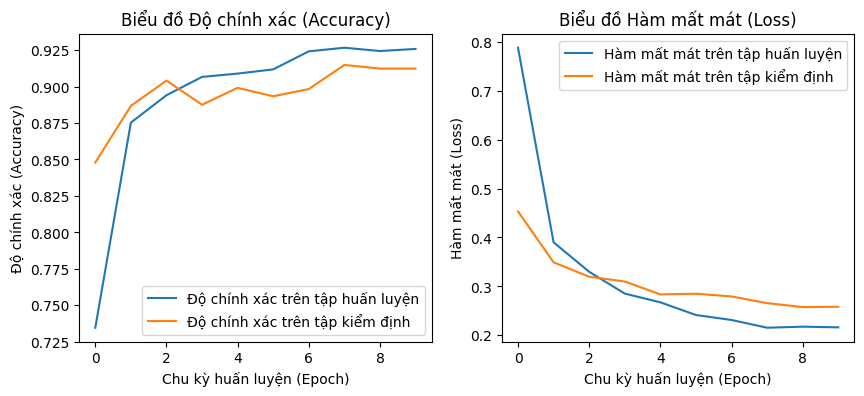

In [ ]:
# 13: BIỂU ĐỒ ĐỘ CHÍNH XÁC (Accuracy) & HÀM MẤT MÁT (Loss)
# Lấy kết quả từ biến 'history'
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# Tạo 2 biểu đồ
plt.figure(figsize=(10, 4))

# Biểu đồ 1: Độ chính xác (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Độ chính xác trên tập huấn luyện')
plt.plot(epochs_range, val_acc, label='Độ chính xác trên tập kiểm định')
plt.legend(loc='lower right')
plt.title('Biểu đồ Độ chính xác (Accuracy)')
plt.xlabel('Chu kỳ huấn luyện (Epoch)')
plt.ylabel('Độ chính xác (Accuracy)')

# Biểu đồ 2: Hàm mất mát (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Hàm mất mát trên tập huấn luyện')
plt.plot(epochs_range, val_loss, label='Hàm mất mát trên tập kiểm định')
plt.legend(loc='upper right')
plt.title('Biểu đồ Hàm mất mát (Loss)')
plt.xlabel('Chu kỳ huấn luyện (Epoch)')
plt.ylabel('Hàm mất mát (Loss)')


# Lưu và hiển thị
plt.savefig('training_validation_plot.png')
plt.show()

--> Đang tính toán Ma trận nhầm lẫn...


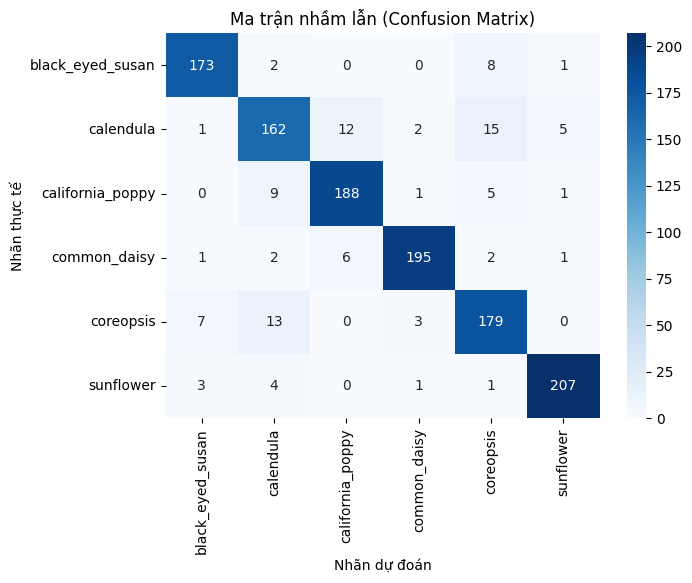

In [ ]:
# 14: MA TRẬN NHẦM LẪN (Confusion Matrix)
# Giúp phân tích chi tiết mô hình hay nhầm lẫn giữa các lớp nào
print("--> Đang tính toán Ma trận nhầm lẫn...")
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Ma trận nhầm lẫn (Confusion Matrix)')
plt.ylabel('Nhãn thực tế')
plt.xlabel('Nhãn dự đoán')
plt.show()

In [ ]:
# 15: BÁO CÁO CHI TIẾT (Classification Report)
# In ra các chỉ số Precision, Recall, F1-Score
print("\n" + "="*60)
print("BẢNG BÁO CÁO PHÂN LOẠI CHI TIẾT (CLASSIFICATION REPORT)")
print("="*60)

# In ra bảng số liệu cụ thể cho từng loài hoa
print(classification_report(y_true, y_pred, target_names=class_names))


BẢNG BÁO CÁO PHÂN LOẠI CHI TIẾT (CLASSIFICATION REPORT)
                  precision    recall  f1-score   support

black_eyed_susan       0.94      0.94      0.94       184
       calendula       0.84      0.82      0.83       197
california_poppy       0.91      0.92      0.92       204
    common_daisy       0.97      0.94      0.95       207
       coreopsis       0.85      0.89      0.87       202
       sunflower       0.96      0.96      0.96       216

        accuracy                           0.91      1210
       macro avg       0.91      0.91      0.91      1210
    weighted avg       0.91      0.91      0.91      1210



**BƯỚC 6: KIỂM THỬ TRÊN TẬP TEST**

In [ ]:
# 16: CHUẨN BỊ DỮ LIỆU TEST (Resize về 224x224)
print(f"--> Đang xử lý ảnh kiểm thử từ: {test_dir}...")

# Tạo một list để chứa 6 ảnh đã xử lý
test_images_preprocessed = []
test_image_names = []

# Sắp xếp để đảm bảo thứ tự
for img_file in sorted(os.listdir(test_dir)):
    img_path = os.path.join(test_dir, img_file)
    if img_file.startswith('.'): continue # Bỏ qua file ẩn (nếu có)

    img = cv2.imread(img_path) #Đọc ảnh (cv2 đọc là BGR)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 đọc ảnh theo BGR, chuyển sang RGB (mô hình học trên RGB)
        img_resized = cv2.resize(img_rgb, (IMG_HEIGHT, IMG_WIDTH)) # 2. Resize ảnh về kích thước chuẩn (224x224)

        # Thêm vào list
        test_images_preprocessed.append(img_resized)
        test_image_names.append(img_file)

# Chuyển list ảnh thành 1 batch (lô) để dự đoán
# Shape sẽ là (6, 224, 224, 3)
test_batch = np.array(test_images_preprocessed)

print(f"Đã tải và resize 6 ảnh test!. Shape của batch: {test_batch.shape}")

--> Đang xử lý ảnh kiểm thử từ: /content/Flower Images/Test_Images...
Đã tải và resize 6 ảnh test!. Shape của batch: (6, 224, 224, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


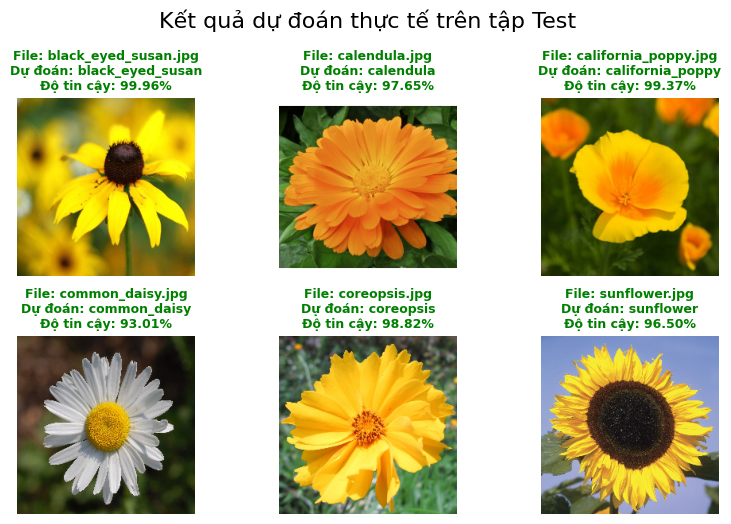

In [ ]:
# 17: DỰ ĐOÁN VÀ HIỂN THỊ KẾT QUẢ
def plot_test_predictions(test_batch, model, class_names, image_names):
    predictions = model.predict(test_batch) # Dùng mô hình để dự đoán
    plt.figure(figsize=(8, 5.3))

    for i in range(len(test_batch)):
        pred_idx = np.argmax(predictions[i])      # Lấy chỉ số (index) của lớp có xác suất cao nhất
        confidence = np.max(predictions[i]) * 100 # Lấy % xác suất
        pred_label = class_names[pred_idx]        # Lấy tên lớp từ chỉ số đó

        plt.subplot(2, 3, i + 1)
        plt.imshow(test_batch[i])

        # Tô màu xanh nếu độ tin cậy cao, đỏ nếu thấp
        text_color = 'green' if confidence > 80 else 'red'
        title_text = f"File: {image_names[i]}\nDự đoán: {pred_label}\nĐộ tin cậy: {confidence:.2f}%"

        plt.title(title_text, color=text_color, fontsize=9, fontweight='bold')
        plt.axis("off")

    plt.suptitle("Kết quả dự đoán thực tế trên tập Test", fontsize=16)
    plt.tight_layout()
    plt.show()

if len(test_batch) > 0:
    plot_test_predictions(test_batch, model, class_names, test_image_names)

**BƯỚC 7: LƯU MODEL**

In [ ]:
# 18: CẤU HÌNH LƯU MODEL - TẠI LOCAL
# Tên file model cuối cùng
MODEL_NAME = 'flower_classifier_mobilenetv2_final.keras'

# Đường dẫn lưu tạm tại ổ cứng Colab (Local Disk)
MODEL_SAVE_PATH = os.path.join('/content', MODEL_NAME)

# THỰC HIỆN LƯU
print(f"--> Đang lưu model vào bộ nhớ tạm Colab: {MODEL_SAVE_PATH}...")
model.save(MODEL_SAVE_PATH)

if os.path.exists(MODEL_SAVE_PATH):
    print(f"✅ Lưu thành công! File hiện đang nằm tại: {MODEL_SAVE_PATH}")
    print("   (Lưu ý: File này sẽ bị xóa khi tắt Google Colab)")
else:
    print("❌ Có lỗi xảy ra, chưa lưu được file!")

--> Đang lưu model vào bộ nhớ tạm Colab: /content/flower_classifier_mobilenetv2_final.keras...
✅ Lưu thành công! File hiện đang nằm tại: /content/flower_classifier_mobilenetv2_final.keras
   (Lưu ý: File này sẽ bị xóa khi tắt Google Colab)


In [ ]:
# 19: SAO LƯU VỀ DRIVE (DÀNH RIÊNG CHO TÁC GIẢ)
import shutil
from google.colab import drive

print("--- [BƯỚC TÙY CHỌN] SAO LƯU MODEL LÊN GOOGLE DRIVE ---")
print("(Bước này giúp giữ lại model sau khi tắt Colab. Người xem khác có thể bỏ qua)")

# Đường dẫn đích trên Drive
DRIVE_FOLDER = '/content/drive/MyDrive/GitHub/Flower-Classification-MobileNetV2/Models/'
DRIVE_DESTINATION = os.path.join(DRIVE_FOLDER, MODEL_NAME)

try:
    # 1. Kết nối Google Drive
    if not os.path.exists('/content/drive'):
        print("--> Đang yêu cầu quyền truy cập Drive để sao lưu...")
        drive.mount('/content/drive')

    # 2. Tạo folder trên Drive nếu chưa có
    if not os.path.exists(DRIVE_FOLDER):
        os.makedirs(DRIVE_FOLDER)
        print(f"--> Đã tạo mới thư mục trên Drive: {DRIVE_FOLDER}")

    # 3. Copy file từ Local sang Drive
    print(f"--> Đang sao chép file '{MODEL_NAME}' sang Drive...")
    shutil.copy(MODEL_SAVE_PATH, DRIVE_DESTINATION)

    print("-" * 50)
    print(f"Model đã được lưu tại:")
    print(f"   📂 {DRIVE_DESTINATION}")
    print("-" * 50)

except Exception as e:
    print("\n⚠️ KHÔNG THỂ LƯU VÀO DRIVE (Nếu là người xem/Guest).")
    print(f"   Chi tiết lỗi: {e}")
    print("💡 MẸO: Bạn có thể tải file thủ công bằng cách mở tab 'Files' bên trái, chuột phải vào file .keras và chọn 'Download'.")

--- [BƯỚC TÙY CHỌN] SAO LƯU MODEL LÊN GOOGLE DRIVE ---
(Bước này giúp giữ lại model sau khi tắt Colab. Người xem khác có thể bỏ qua)
--> Đang sao chép file 'flower_classifier_mobilenetv2_final.keras' sang Drive...
--------------------------------------------------
Model đã được lưu tại:
   📂 /content/drive/MyDrive/GitHub/Flower-Classification-MobileNetV2/Models/flower_classifier_mobilenetv2_final.keras
--------------------------------------------------
